In [39]:
%matplotlib inline

from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiime2 import Artifact, Metadata
from qiime2.plugins import diversity, empress
import scipy.stats as ss
from skbio.tree import TreeNode
import tqdm

# Figure 1A - Full EMP Visualization

In [2]:
# Clear the output directory and create a fresh one
!rm -rf output/*
!mkdir -p output

## Downloading Required Data

First, we will download the EMP data via FTP. Note that we do not include these files in the repository because they are fairly large.

In [3]:
# EMP table
!wget -O ../data/EMP/EMP_tbl.biom ftp://ftp.microbio.me/emp/release1/otu_tables/deblur/emp_deblur_90bp.release1.biom

--2020-09-29 14:58:04--  ftp://ftp.microbio.me/emp/release1/otu_tables/deblur/emp_deblur_90bp.release1.biom
           => ‘../data/EMP/EMP_tbl.biom’
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /emp/release1/otu_tables/deblur ... done.
==> SIZE emp_deblur_90bp.release1.biom ... 269396269
==> PASV ... done.    ==> RETR emp_deblur_90bp.release1.biom ... done.
Length: 269396269 (257M) (unauthoritative)

emp_deblur_90bp.rel 100%[===================>] 256.92M  3.11MB/s    in 1m 54s  

2020-09-29 14:59:58 (2.25 MB/s) - ‘../data/EMP/EMP_tbl.biom’ saved [269396269]



In [4]:
# EMP tree
!wget -O ../data/EMP/EMP_tree.tre ftp://ftp.microbio.me/emp/release1/otu_info/deblur/emp90.5000_1000_rxbl_placement_pruned75.tog.tre

--2020-09-29 14:59:58--  ftp://ftp.microbio.me/emp/release1/otu_info/deblur/emp90.5000_1000_rxbl_placement_pruned75.tog.tre
           => ‘../data/EMP/EMP_tree.tre’
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /emp/release1/otu_info/deblur ... done.
==> SIZE emp90.5000_1000_rxbl_placement_pruned75.tog.tre ... 41472507
==> PASV ... done.    ==> RETR emp90.5000_1000_rxbl_placement_pruned75.tog.tre ... done.
Length: 41472507 (40M) (unauthoritative)

emp90.5000_1000_rxb 100%[===================>]  39.55M  1.88MB/s    in 27s     

2020-09-29 15:00:26 (1.45 MB/s) - ‘../data/EMP/EMP_tree.tre’ saved [41472507]



In [5]:
# EMP mapping file
!wget -O ../data/EMP/EMP_metadata.tsv ftp://ftp.microbio.me/emp/release1/mapping_files/emp_qiime_mapping_release1.tsv

--2020-09-29 15:00:26--  ftp://ftp.microbio.me/emp/release1/mapping_files/emp_qiime_mapping_release1.tsv
           => ‘../data/EMP/EMP_metadata.tsv’
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /emp/release1/mapping_files ... done.
==> SIZE emp_qiime_mapping_release1.tsv ... 21876184
==> PASV ... done.    ==> RETR emp_qiime_mapping_release1.tsv ... done.
Length: 21876184 (21M) (unauthoritative)

emp_qiime_mapping_r 100%[===================>]  20.86M  4.88MB/s    in 3.7s    

2020-09-29 15:00:30 (5.69 MB/s) - ‘../data/EMP/EMP_metadata.tsv’ saved [21876184]



In [21]:
# EMP sequences
!wget -O ../data/EMP/EMP_seqs.fa ftp://ftp.microbio.me/emp/release1/otu_info/deblur/emp.90.min25.deblur.seq.fa

--2020-09-29 15:11:10--  ftp://ftp.microbio.me/emp/release1/otu_info/deblur/emp.90.min25.deblur.seq.fa
           => ‘../data/EMP/EMP_seqs.fa’
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /emp/release1/otu_info/deblur ... done.
==> SIZE emp.90.min25.deblur.seq.fa ... 63249192
==> PASV ... done.    ==> RETR emp.90.min25.deblur.seq.fa ... done.
Length: 63249192 (60M) (unauthoritative)

emp.90.min25.deblur 100%[===================>]  60.32M  6.63MB/s    in 9.3s    

2020-09-29 15:11:19 (6.48 MB/s) - ‘../data/EMP/EMP_seqs.fa’ saved [63249192]



Next, we'll import the table and tree files as `qza` Artifacts so that they can be used with EMPress.

In [6]:
!qiime tools import \
    --type FeatureTable[Frequency] \
    --input-path ../data/EMP/EMP_tbl.biom \
    --output-path ../data/EMP/EMP_tbl.qza

Imported ../data/EMP/EMP_tbl.biom as BIOMV210DirFmt to ../data/EMP/EMP_tbl.qza


In [7]:
!qiime tools import \
    --type Phylogeny[Rooted] \
    --input-path ../data/EMP/EMP_tree.tre \
    --output-path ../data/EMP/EMP_tree.qza

Imported ../data/EMP/EMP_tree.tre as NewickDirectoryFormat to ../data/EMP/EMP_tree.qza


## Simplify Phylum-Level Assignments

For ease of visualization, we will use each microbial feature's phylum level assignment for subsequent taxonomic representation. These assignments are stored within the original `biom` table. We will first extract this file and replace missing values with "Unspecified."

In [10]:
tbl_biom = load_table("../data/EMP/EMP_tbl.biom")
taxonomy_df = tbl_biom.metadata_to_dataframe(axis="observation")
#taxonomy_df.columns = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
taxonomy_df.index.name = "featureid"
taxonomy_df = taxonomy_df.fillna("Unspecified")
print(taxonomy_df.shape)
taxonomy_df.head()

(317314, 7)


,taxonomy_0,taxonomy_1,taxonomy_2,taxonomy_3,taxonomy_4,taxonomy_5,taxonomy_6
featureid,,,,,,,
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTGTTTAAGCTAGCTGTGAAAGCCCCGGGCTTAAC,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Alteromonadaceae,g__Marinimicrobium,s__
TACAGAGGTCCCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGCTCGTAGGTGGCCAACTAAGTCAGACGTGAAATCCCTCGGCTTAAC,k__Bacteria,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified
TACGAAGGGTGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGGTCCGTGTGTCGGTTGTGAAATCCCTGGGCTCAAC,k__Bacteria,p__Proteobacteria,c__Deltaproteobacteria,Unspecified,Unspecified,Unspecified,Unspecified
TACGGAGTGTGCAAGCGTTACTCGGAATCACTGGGCATAAAGAGCACGTAGGCGGGTCACCAAGTCAGCCGTGAAAGCCCCCGGCCCAAC,k__Bacteria,p__Planctomycetes,c__028H05-P-BN-P5,o__,f__,g__,s__
TACGAGAGGTCCAAACGTTATTCGGAATTACTGGGCTTAAAGAGTTCGTAGGCGGCTAAGTAAGTGGGATGTGAAAGCCCTCGGCTCAAC,k__Bacteria,p__Planctomycetes,c__Planctomycetia,o__Pirellulales,f__Pirellulaceae,g__,s__


We want to keep only the top 5 most abundant phlyum (taxonomy_1) assignments.

In [11]:
taxonomy_df["taxonomy_1"].value_counts().head(6) # top 5 + Unspecified

p__Proteobacteria    83037
Unspecified          44143
p__Bacteroidetes     26406
p__Firmicutes        23834
p__Planctomycetes    22177
p__Chloroflexi       16042
Name: taxonomy_1, dtype: int64

In [12]:
top_5_phyla_counts = taxonomy_df["taxonomy_1"].value_counts()[:6]
top_5_phyla = top_5_phyla_counts.index.tolist()
bot_phyla = taxonomy_df["taxonomy_1"].value_counts()[6:].index.tolist()
top_5_phyla.remove("Unspecified")
bot_phyla.append("Unspecified")
phylum_assignments = ["Other/Unspecified" if not x in top_5_phyla else x for x in taxonomy_df["taxonomy_1"]]
top_5_phyla_df = pd.DataFrame.from_dict(dict(zip(taxonomy_df.index.tolist(), phylum_assignments)), orient="index")
top_5_phyla_df.columns = ["phylum_assignment"]
top_5_phyla_df.index.name = "featureid"
top_5_phyla_df.head()

,phylum_assignment
featureid,
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTGTTTAAGCTAGCTGTGAAAGCCCCGGGCTTAAC,p__Proteobacteria
TACAGAGGTCCCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGCTCGTAGGTGGCCAACTAAGTCAGACGTGAAATCCCTCGGCTTAAC,Other/Unspecified
TACGAAGGGTGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGGTCCGTGTGTCGGTTGTGAAATCCCTGGGCTCAAC,p__Proteobacteria
TACGGAGTGTGCAAGCGTTACTCGGAATCACTGGGCATAAAGAGCACGTAGGCGGGTCACCAAGTCAGCCGTGAAAGCCCCCGGCCCAAC,p__Planctomycetes
TACGAGAGGTCCAAACGTTATTCGGAATTACTGGGCTTAAAGAGTTCGTAGGCGGCTAAGTAAGTGGGATGTGAAAGCCCTCGGCTCAAC,p__Planctomycetes


We will save this file as a `tsv` file that QIIME2 can read.

In [14]:
Metadata(top_5_phyla_df).save("../data/EMP/EMP_top_5_phyla.tsv")

## Filtering Feature Table

The original EMP data includes samples from both sterile water blanks and mock communities. We will remove samples of both these types. Additionally, we will filter the feature table by the phylogeny to make sure all features present in the feature table are present in the phylogeny as well.

In [22]:
!qiime feature-table filter-samples \
    --i-table ../data/EMP/EMP_tbl.qza \
    --m-metadata-file ../data/EMP/EMP_metadata.tsv \
    --p-where "[empo_2] NOT IN ('Positive', 'Negative')" \
    --o-filtered-table ../data/EMP/EMP_tbl_filt.qza

!qiime phylogeny filter-table \
    --i-table ../data/EMP/EMP_tbl_filt.qza \
    --i-tree ../data/EMP/EMP_tree.qza \
    --o-filtered-table ../data/EMP/EMP_tbl_filt.qza

Saved FeatureTable[Frequency] to: ../data/EMP/EMP_tbl_filt.qza
Saved FeatureTable[Frequency] to: ../data/EMP/EMP_tbl_filt.qza


## Running EMPress

Finally, we will generate an EMPire plot combining an interactive tree visualization with a PCoA. The PCoA is very computationally intensive to calculate so we have omitted it here. The code used to generate the unweighted UniFrac distance matrix and PCoA are shown below (not executed).

```bash
qiime diversity beta-phylogenetic \
    --i-table ../data/EMP/EMP_tbl_filt.qza \
    --i-phylogeny ../data/EMP/EMP_tree.qza \
    --p-metric unweighted_unifrac \
    --p-n-jobs 32 \
    --o-distance-matrix ../results/EMP/EMP_u_unifrac_dm.qza
    
qiime diversity pcoa \
    --i-distance-matrix ../data/EMP/EMP_u_unifrac_dm.qza \
    --p-number-of-dimensions 3 \
    --o-pcoa ../results/EMP/EMP_u_unifrac_pcoa.qza
```

In [23]:
!qiime empress plot \
    --i-tree ../data/EMP/EMP_tree.qza \
    --i-feature-table ../data/EMP/EMP_tbl_filt.qza \
    --i-pcoa ../results/EMP/EMP_u_unifrac_pcoa.qza \
    --m-sample-metadata-file ../data/EMP/EMP_metadata.tsv \
    --m-feature-metadata-file ../data/EMP/EMP_top_5_phyla.tsv \
    --o-visualization ../results/EMP/EMP_empire.qzv

Saved Visualization to: ../results/EMP/EMP_empire.qzv


# Figure 1B

Now we will recreate the subtree with the pH metadata. First, we will import the sample metadata to see the overall distribution of pH values.

In [26]:
metadata = pd.read_csv("../data/EMP/EMP_metadata.tsv", sep="\t", index_col=0)
metadata.head()

,BarcodeSequence,LinkerPrimerSequence,Description,host_subject_id,study_id,title,principal_investigator,doi,ebi_accession,target_gene,...,adiv_shannon,adiv_faith_pd,temperature_deg_c,ph,salinity_psu,oxygen_mg_per_l,phosphate_umol_per_l,ammonium_umol_per_l,nitrate_umol_per_l,sulfate_umol_per_l
#SampleID,,,,,,,,,,,,,,,,,,,,,
550.L1S1.s.1.sequence,AACGCACGCTAG,GTGCCAGCMGCCGCGGTAA,sample_1 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,4.244831,13.631804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S10.s.1.sequence,ACAGACCACTCA,GTGCCAGCMGCCGCGGTAA,sample_2 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.027416,9.425835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S100.s.1.sequence,ATGCACTGGCGA,GTGCCAGCMGCCGCGGTAA,sample_3 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.196420,10.491161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S101.s.1.sequence,ATTATCGTGCAC,GTGCCAGCMGCCGCGGTAA,sample_4 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.714719,11.384689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550.L1S102.s.1.sequence,CACGACAGGCTA,GTGCCAGCMGCCGCGGTAA,sample_5 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,16S rRNA,...,3.969038,15.162691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


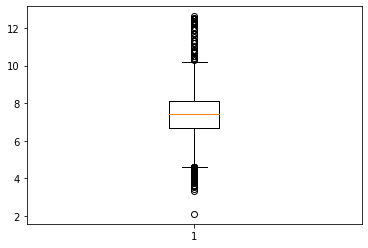

In [30]:
ph_vals = metadata["ph"].dropna()
plt.boxplot(ph_vals)
plt.show()

To remove outliers, we are going to retain only the middle 90% of the range of pH values.

In [36]:
q1, q2 = [ph_vals.quantile(x) for x in [0.05, 0.95]]
print(q1, q2)

4.7 9.0


In [38]:
!qiime feature-table filter-samples \
    --i-table ../data/EMP/EMP_tbl_filt.qza \
    --m-metadata-file ../data/EMP/EMP_metadata.tsv \
    --p-where "[ph] >= 4.7 AND [ph] <= 9" \
    --o-filtered-table ../data/EMP/ph_EMP_tbl_filt.qza

Saved FeatureTable[Frequency] to: ../data/EMP/ph_EMP_tbl_filt.qza


In [42]:
ph_tbl_df = Artifact.load("../data/EMP/ph_EMP_tbl_filt.qza").view(pd.DataFrame)
features = ph_tbl_df.columns.tolist()
feature_ph_dict = dict()

for feature in tqdm.tqdm(features):
    feature_ph_dict[feature] = dict()
    samps = ph_tbl_df.loc[:, feature]
    samps = samps[samps > 0].index.tolist()
    ph_vals = metadata.loc[samps]["ph"].tolist()
    feature_ph_dict[feature]["sample_presence"] = len(samps)
    feature_ph_dict[feature]["geometric_mean"] = ss.mstats.gmean(ph_vals)
    feature_ph_dict[feature]["arithmetic_mean"] = np.mean(ph_vals)
    
ph_mean_df = pd.DataFrame.from_dict(feature_ph_dict, orient="index")
ph_mean_df.index.name = "featureid"
ph_mean_df.head()

100%|██████████| 193152/193152 [04:56<00:00, 651.93it/s]


,sample_presence,geometric_mean,arithmetic_mean
featureid,,,
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTGTTTAAGCTAGCTGTGAAAGCCCCGGGCTTAAC,2,8.558505,8.560000
TACAGAGGTCCCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGCTCGTAGGTGGCCAACTAAGTCAGACGTGAAATCCCTCGGCTTAAC,2,5.494616,5.495000
TACGAAGGGTGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGGTCCGTGTGTCGGTTGTGAAATCCCTGGGCTCAAC,10,7.045974,7.100000
TACGGAGTGTGCAAGCGTTACTCGGAATCACTGGGCATAAAGAGCACGTAGGCGGGTCACCAAGTCAGCCGTGAAAGCCCCCGGCCCAAC,17,7.830167,7.852941
TACGAGAGGTCCAAACGTTATTCGGAATTACTGGGCTTAAAGAGTTCGTAGGCGGCTAAGTAAGTGGGATGTGAAAGCCCTCGGCTCAAC,26,7.602140,7.613846


In [48]:
ph_mean_df["log10_sample_presence"] = ph_mean_df["sample_presence"].apply(np.log10)

In [49]:
Metadata(ph_mean_df).save("../data/EMP/ph_EMP_feature_metadata.tsv")

In [50]:
!qiime empress plot \
    --i-tree ../data/EMP/EMP_tree.qza \
    --i-feature-table ../data/EMP/ph_EMP_tbl_filt.qza \
    --m-sample-metadata-file ../data/EMP/EMP_metadata.tsv \
    --m-feature-metadata-file ../data/EMP/EMP_top_5_phyla.tsv \
    --m-feature-metadata-file ../data/EMP/ph_EMP_feature_metadata.tsv \
    --o-visualization ../results/EMP/ph_EMP_empire.qzv

Saved Visualization to: ../results/EMP/ph_EMP_empire.qzv
